In [ ]:
import keras
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Count is used to train

In [ ]:
count = pd.read_csv('excel_files/prepared.csv')

In [ ]:
count['user'] = count.user.astype('category').cat.codes.values
count['item'] = count.item.astype('category').cat.codes.values

In [ ]:
count.head()

In [ ]:
df = pd.read_csv('excel_files/diff.csv')

In [ ]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df.rename({'fullname_X':'user','product_id':'item'},axis =1, inplace=True)
df['nuser'] = df.user.astype('category').cat.codes.values
df['nitem'] = df.item.astype('category').cat.codes.values

# df is used for mapping only

In [7]:
df.head()

,user,item,product_name,created_day,diff,nuser,nitem
0,255495,7,Send Money,2018-08-06,91,29565,2
1,359354,200,NT Prepaid Topup,2018-08-06,91,44546,29
2,429302,200,NT Prepaid Topup,2018-08-06,91,57521,29
3,402598,15,Ncell Topup,2018-08-06,91,52299,5
4,483671,200,NT Prepaid Topup,2018-08-06,91,69014,29


# Create The Dictionery Mapping


In [8]:
item_dict = dict(zip(df.nitem,df.product_name))
user_dict=dict(zip(df.nuser,df.user))

# Simple Matrix Factorization


In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(count, test_size=0.2)

In [10]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_item = len(df.user.unique()), len(df.item.unique())
n_latent_factors = 5

In [11]:
item_input = keras.layers.Input(shape=[1],name='Item')
item_embedding = keras.layers.Embedding(n_item + 1, n_latent_factors, name='item-Embedding')(item_input)
item_vec = keras.layers.Flatten(name='FlattenItems')(item_embedding)

In [12]:
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

In [18]:
prod = keras.layers.dot([user_vec, item_vec],axes=1)

In [19]:
model = keras.Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error')

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         672905      User[0][0]                       
__________________________________________________________________________________________________
item-Embedding (Embedding)      (None, 1, 5)         1640        Item[0][0]                       
__________________________________________________________________________________________________
FlattenUse

In [104]:
prod

<tf.Tensor 'dot_2/ExpandDims:0' shape=(?, 1) dtype=float32>

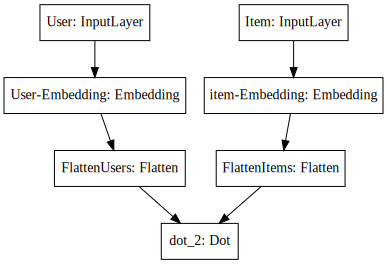

In [24]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [30]:
history = model.fit([train.user, train.item], train.counts, epochs=10, verbose=1)

Epoch 1/10
417454/417454 [==============================] - 66s 158us/step - loss: 158.1771
Epoch 2/10
417454/417454 [==============================] - 67s 160us/step - loss: 118.5980
Epoch 3/10
417454/417454 [==============================] - 69s 166us/step - loss: 90.6377
Epoch 4/10
417454/417454 [==============================] - 67s 162us/step - loss: 75.9322
Epoch 5/10
417454/417454 [==============================] - 68s 163us/step - loss: 68.1716
Epoch 6/10
417454/417454 [==============================] - 73s 175us/step - loss: 64.0774
Epoch 7/10
417454/417454 [==============================] - 75s 181us/step - loss: 61.7620
Epoch 8/10
417454/417454 [==============================] - 73s 175us/step - loss: 60.3631
Epoch 9/10
417454/417454 [==============================] - 72s 174us/step - loss: 59.5139
Epoch 10/10
417454/417454 [==============================] - 70s 168us/step - loss: 58.9550


In [31]:
model.save('models/simpleMatFact.h5')

# Validating the Model

Text(0,0.5,'Train Error')

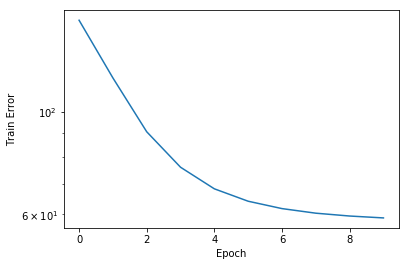

In [35]:
import matplotlib.pyplot as plt 
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [36]:
y_hat = (model.predict([test.user, test.item]))
y_true = test.counts

In [37]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

5.260057699427625

# non negative Matrix Factorization


In [115]:
from keras.constraints import non_neg
item_input = keras.layers.Input(shape=[1],name='Item')
item_embedding = keras.layers.Embedding(n_item + 1, n_latent_factors, name='item-Embedding')(item_input)
item_vec = keras.layers.Flatten(name='FlattenItems')(item_embedding)
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding',embeddings_constraint=non_neg())(user_input))
prod = keras.layers.dot([item_vec, user_vec],axes=1)
model = keras.Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error')

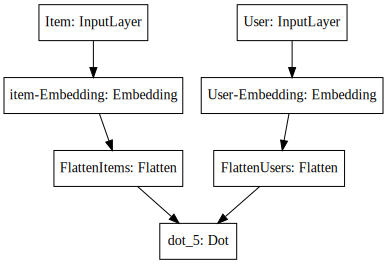

In [116]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(model, to_file='Mat Fact.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [41]:
history = model.fit([train.user, train.item], train.counts, epochs=10, verbose=1)

Epoch 1/10
417454/417454 [==============================] - 77s 184us/step - loss: 150.6170
Epoch 2/10
417454/417454 [==============================] - 73s 176us/step - loss: 110.6814
Epoch 3/10
417454/417454 [==============================] - 73s 174us/step - loss: 86.3512
Epoch 4/10
417454/417454 [==============================] - 75s 180us/step - loss: 73.9212
Epoch 5/10
417454/417454 [==============================] - 75s 180us/step - loss: 67.2646
Epoch 6/10
417454/417454 [==============================] - 73s 176us/step - loss: 63.7747
Epoch 7/10
417454/417454 [==============================] - 73s 176us/step - loss: 61.6709
Epoch 8/10
417454/417454 [==============================] - 75s 180us/step - loss: 60.4502
Epoch 9/10
417454/417454 [==============================] - 72s 171us/step - loss: 59.8992
Epoch 10/10
417454/417454 [==============================] - 70s 168us/step - loss: 59.2537


In [42]:
model.save('models/NonNegMatFact.h5')

In [43]:
y_hat = (model.predict([test.user, test.item]))
y_true = test.counts
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

5.157693350041778

# Using Neural Networks

In [14]:
n_latent_factors_user = 5
n_latent_factors_item = 8

item_input = keras.layers.Input(shape=[1],name='Item')
item_embedding = keras.layers.Embedding(n_item + 1, n_latent_factors_item, name='item-Embedding')(item_input)
item_vec = keras.layers.Flatten(name='FlattenMovies')(item_embedding)
item_vec = keras.layers.Dropout(0.2)(item_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.concatenate([item_vec, user_vec],name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected',activation='softmax')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1',activation='softmax')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2',activation='softmax')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='softmax')(dense_3)


result = keras.layers.Dense(1, activation='softmax',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, item_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error',metrics=['accuracy'])

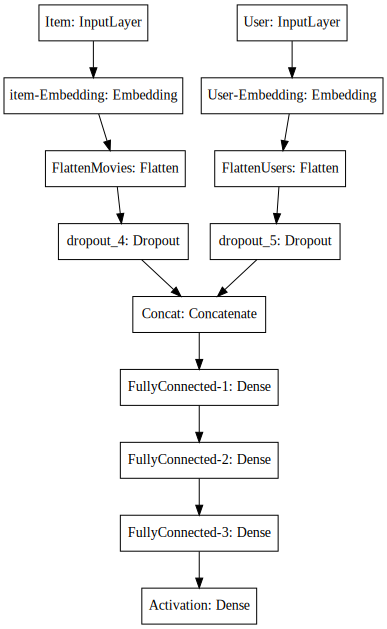

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(model, to_file='neural.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item-Embedding (Embedding)      (None, 1, 8)         2624        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         672905      User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [ ]:
history = model.fit([train.user, train.item], train.counts, epochs=10, verbose=1,validation_split=.1,)

Train on 375708 samples, validate on 41746 samples
Epoch 1/10
375708/375708 [==============================] - 93s 249us/step - loss: 5.3886 - acc: 0.3672 - val_loss: 5.4866 - val_acc: 0.3677
Epoch 2/10
375708/375708 [==============================] - 85s 227us/step - loss: 5.3886 - acc: 0.3672 - val_loss: 5.4866 - val_acc: 0.3677
Epoch 3/10
375708/375708 [==============================] - 85s 226us/step - loss: 5.3886 - acc: 0.3672 - val_loss: 5.4866 - val_acc: 0.3677
Epoch 4/10
375708/375708 [==============================] - 84s 224us/step - loss: 5.3886 - acc: 0.3672 - val_loss: 5.4866 - val_acc: 0.3677
Epoch 5/10
279328/375708 [=====================>........] - ETA: 27s - loss: 5.4058 - acc: 0.3675

In [46]:
model.save('models/neural.h5')

In [47]:
y_hat = (model.predict([test.user, test.item]))
y_true = test.counts
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

5.367780077421333